In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from scipy.optimize import curve_fit
import xarray as xr
from global_land_mask import globe
import cartopy.crs as ccrs
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500

In [3]:
a = '/media/rakshith/Seagate Expansion Drive/mraks/ERA Prec, Pwat all region.nc'
ds = xr.open_dataset(a)

In [4]:
region = str(input('Enter the region for comparision\n I=India, BOB=Bay of Bengal, EIO=Equitorial Indian Ocean\n'))
                   
if region=='I':
        lat1, lat2, lon1, lon2 = 30, 10, 70, 90
        region='India'
        str1='-'
elif region=='BOB':
        lat1, lat2, lon1, lon2 = 20, 10, 85, 95
        region='Bay of Bengal'
        str1='-'
elif region=='EIO':
        lat1, lat2, lon1, lon2 = 5, -5, 90, 100
        region='Equitorial Indian Ocean'
        str1='S-'
else:
    print('Please enter proper code')

Enter the region for comparision
 I=India, BOB=Bay of Bengal, EIO=Equitorial Indian Ocean
I


In [5]:
#For JJAS
#jjas = data.time.dt.month.isin(range(6, 10))
#clim = data.sel(time=jjas) #ds with only JJAS months

#For all months
clim=ds
clim2 = clim.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))

In [6]:
year1='1940'
year2='1960'
year3='2002'
year4='2022'
grid1 = clim2.sel(time=slice(year1, year2))
grid2 = clim2.sel(time=slice(year3, year4))
    
l=[]
for i in grid1.longitude:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, grid1.latitude)
mask = globe.is_land(lat_grid, lon_grid)

In [7]:
if region=='India':
    Pwat1 = grid1.tcwv.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr1 = 86400*grid1.mtpr.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
    Pwat2 = grid2.tcwv.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr2 = 86400*grid2.mtpr.where(mask>0).mean(dim=['latitude', 'longitude']).squeeze()
else:
    Pwat1 = grid1.tcwv.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr1 = 86400*grid1.mtpr.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pwat2 = grid2.tcwv.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()
    Pr2 = 86400*grid2.mtpr.where(mask==0).mean(dim=['latitude', 'longitude']).squeeze()

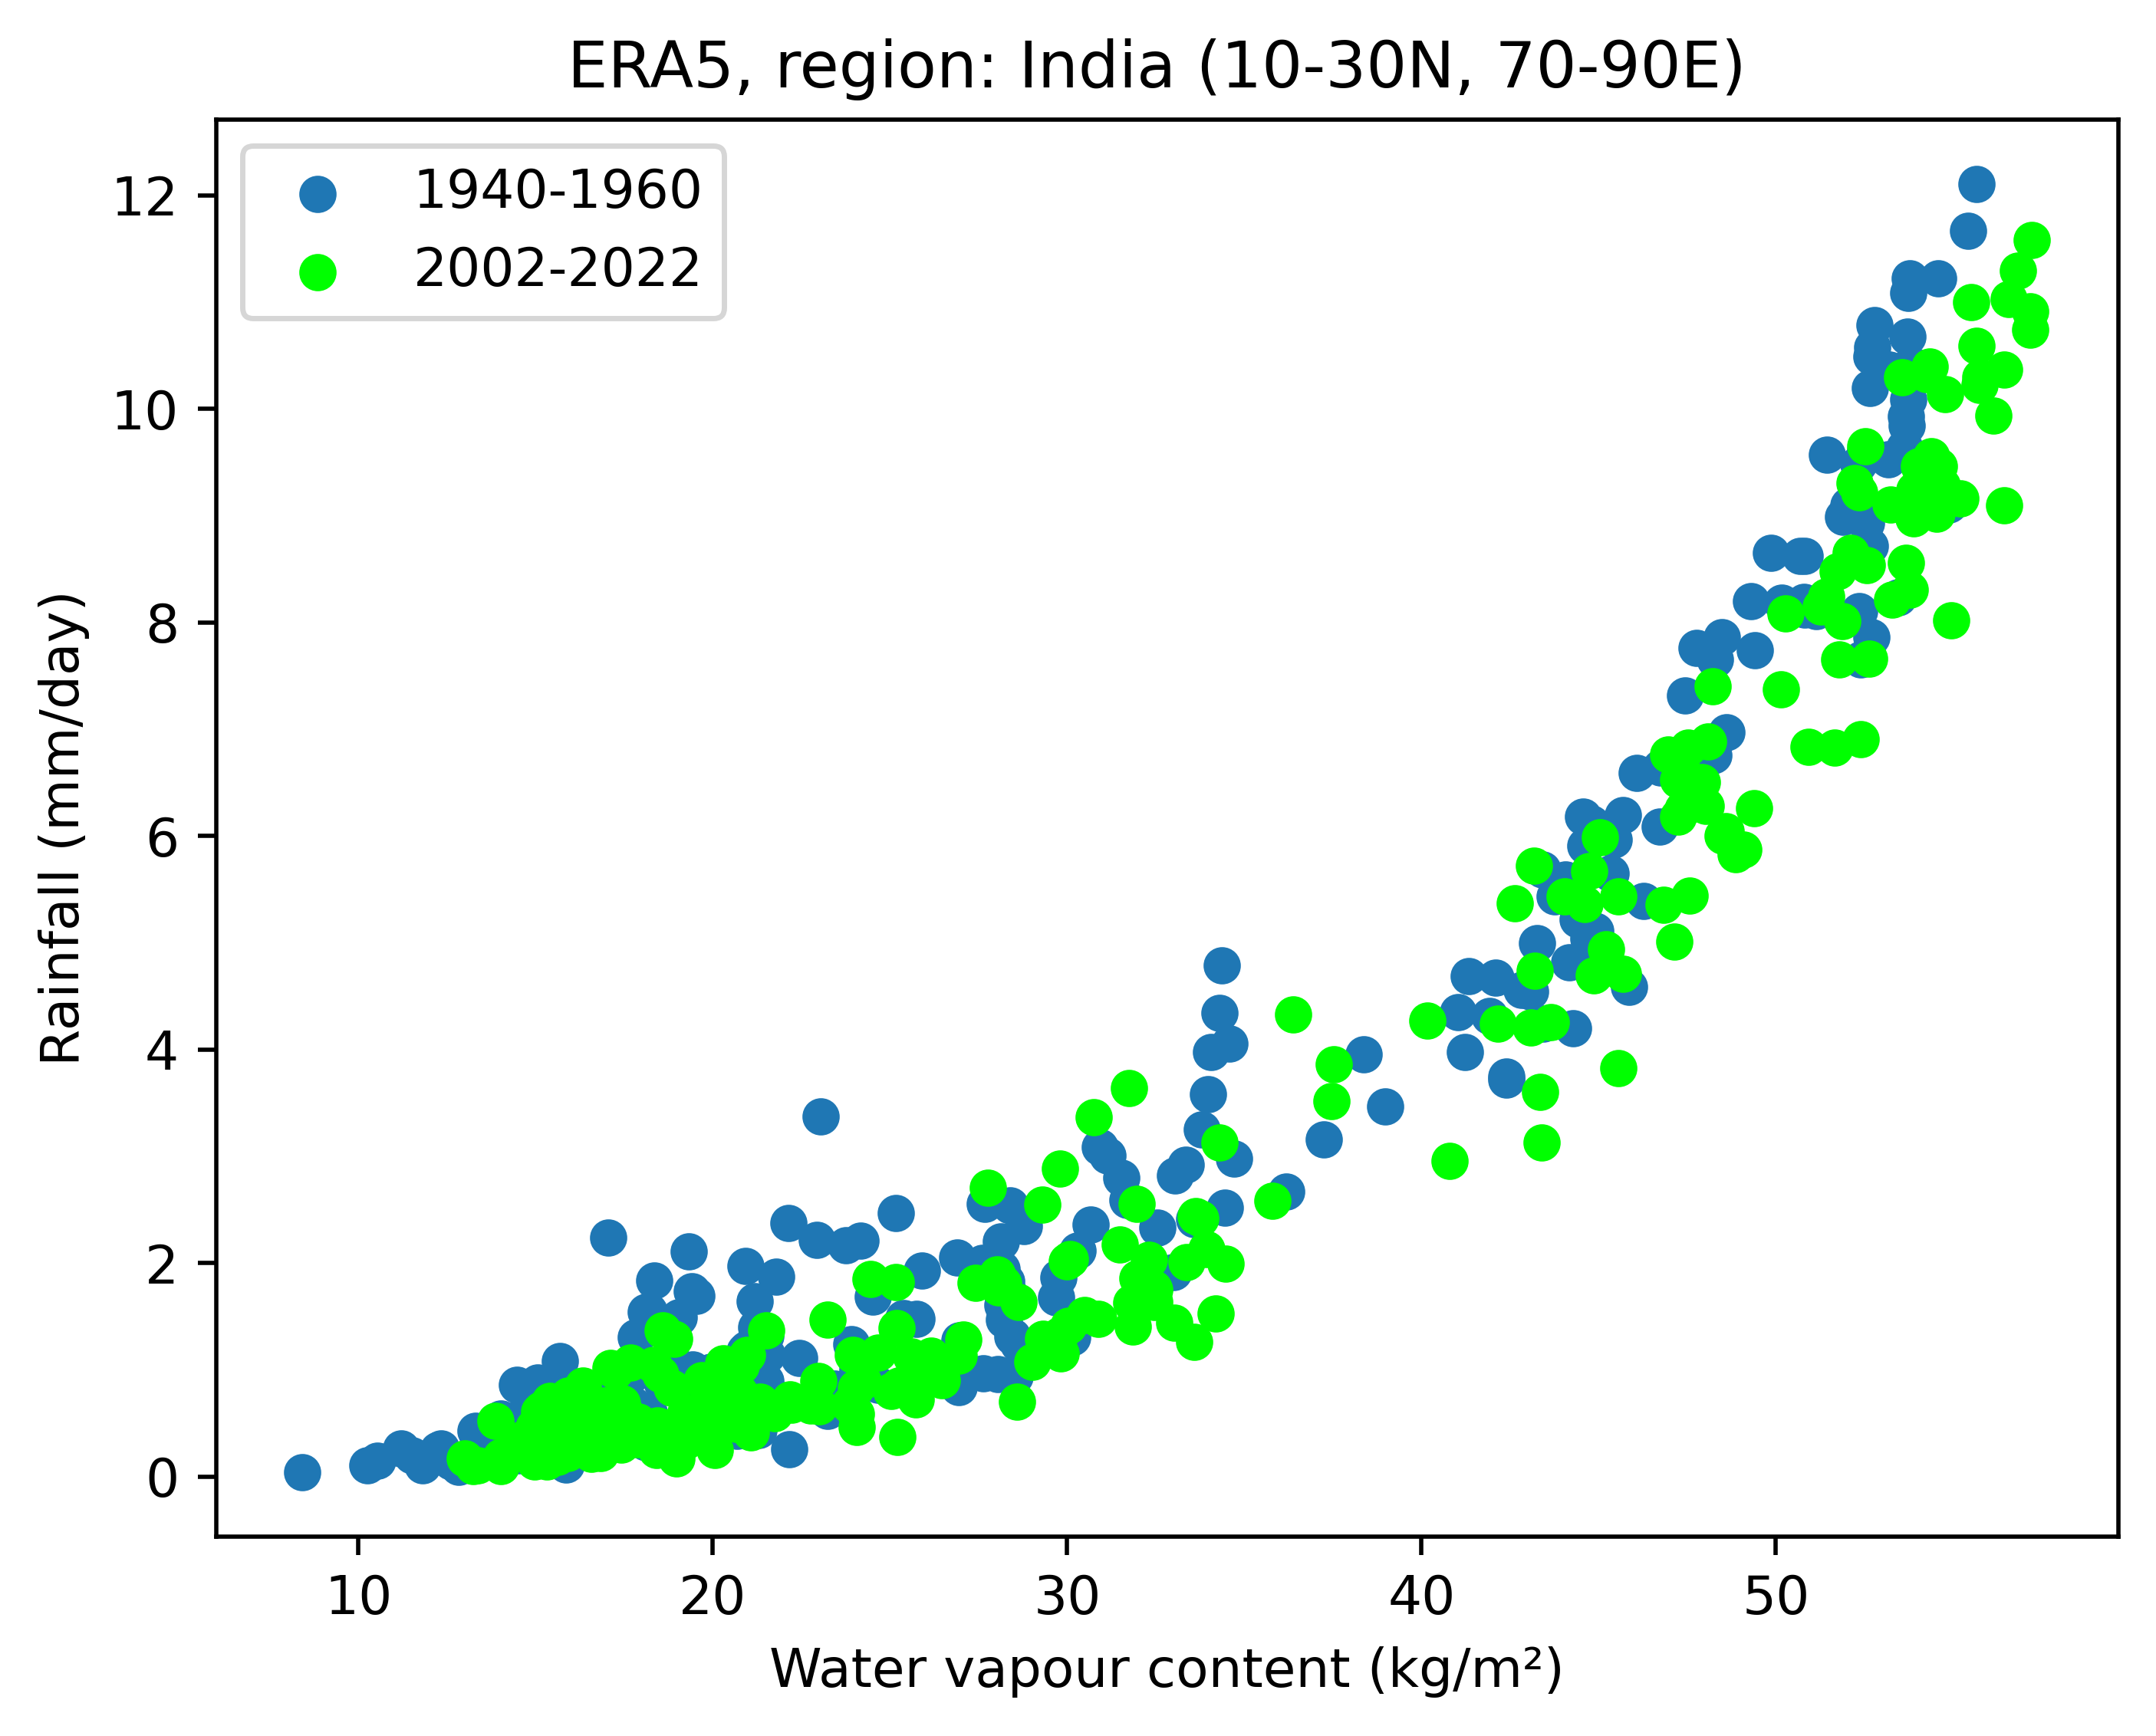

In [8]:
plt.scatter(Pwat1, Pr1, label=year1 + '-' + year2)
plt.scatter(Pwat2, Pr2, label=year3 + '-' + year4, c='lime')
plt.xlabel('Water vapour content (kg/m\u00b2)')
plt.ylabel('Rainfall (mm/day)')
plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))
#plt.title('Only months June-September')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ERA5, region: India (10-30N, 70-90E) ')

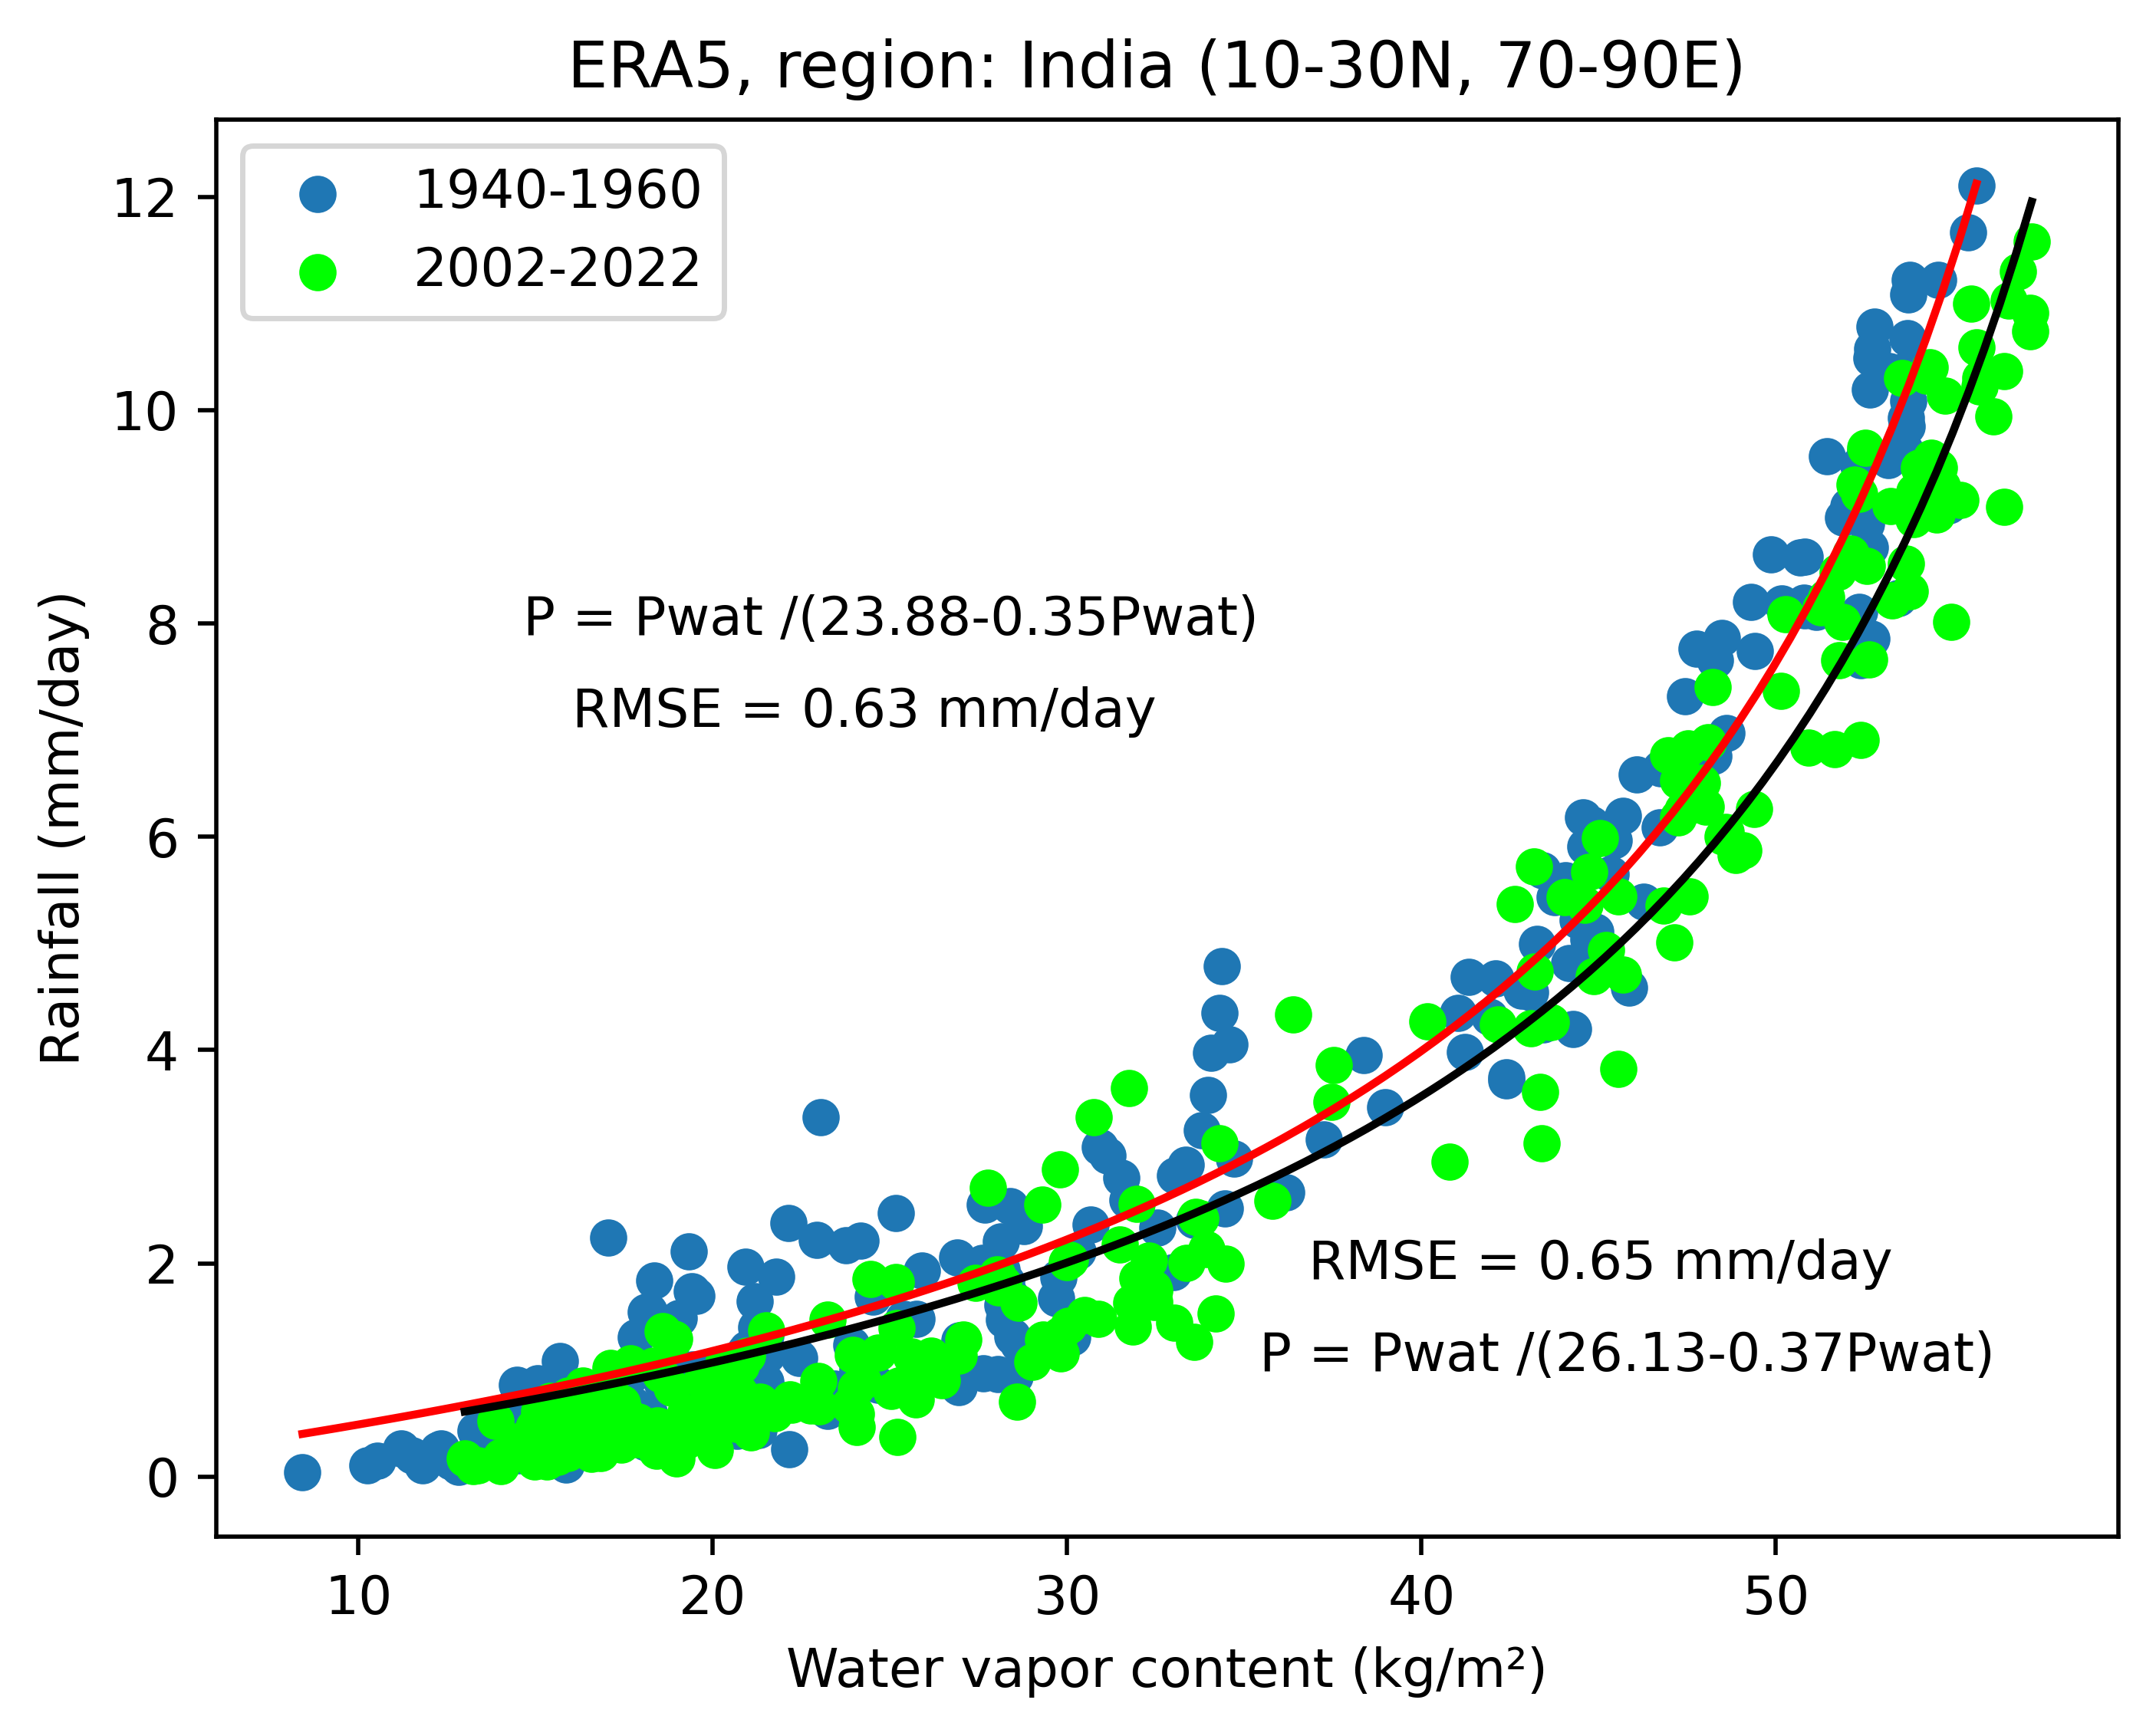

In [10]:
x1, y1 = Pwat1.values, Pr1.values
x2, y2 = Pwat2.values, Pr2.values

def objective(x, a, b):
    return x/(a-b*x)

p0 = [80, 0.5]

popt1, _ = curve_fit(objective, x1, y1, p0)
popt2, _ = curve_fit(objective, x2, y2, p0)
a1, b1 = popt1
a2, b2 = popt2

x_line1 = np.linspace(np.min(x1), np.max(x1), 100)
x_line2 = np.linspace(np.min(x2), np.max(x2), 100)
y_line1 = objective(x_line1, a1, b1)
y_line2 = objective(x_line2, a2, b2)

pred1 = objective(x1, a1, b1)
pred2 = objective(x2, a2, b2)

from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y1, pred1, squared=False)
rmse2 = mean_squared_error(y2, pred2, squared=False)

plt.scatter(Pwat1, Pr1, label=year1 + '-' + year2)
plt.scatter(Pwat2, Pr2, label=year3 + '-' + year4, c='lime')
plt.plot(x_line1, y_line1, c='r')
plt.plot(x_line2, y_line2, c='black')
plt.figtext(0.25, 0.6, 'P = Pwat /(%.2f-%.2fPwat)' % (a1, b1))
plt.figtext(0.55, 0.2, 'P = Pwat /(%.2f-%.2fPwat)' % (a2, b2))
plt.figtext(0.27, 0.55, 'RMSE = %.2f mm/day' % (rmse1))
plt.figtext(0.57, 0.25, 'RMSE = %.2f mm/day' % (rmse2))
plt.xlabel('Water vapor content (kg/m\u00b2)')
plt.ylabel('Rainfall (mm/day)')
plt.legend()
plt.title('ERA5, region: '+ region + " ({}".format(abs(lat2)) + str1 +"{}N, {}-{}E) ".format(abs(lat1), abs(lon1), abs(lon2)))

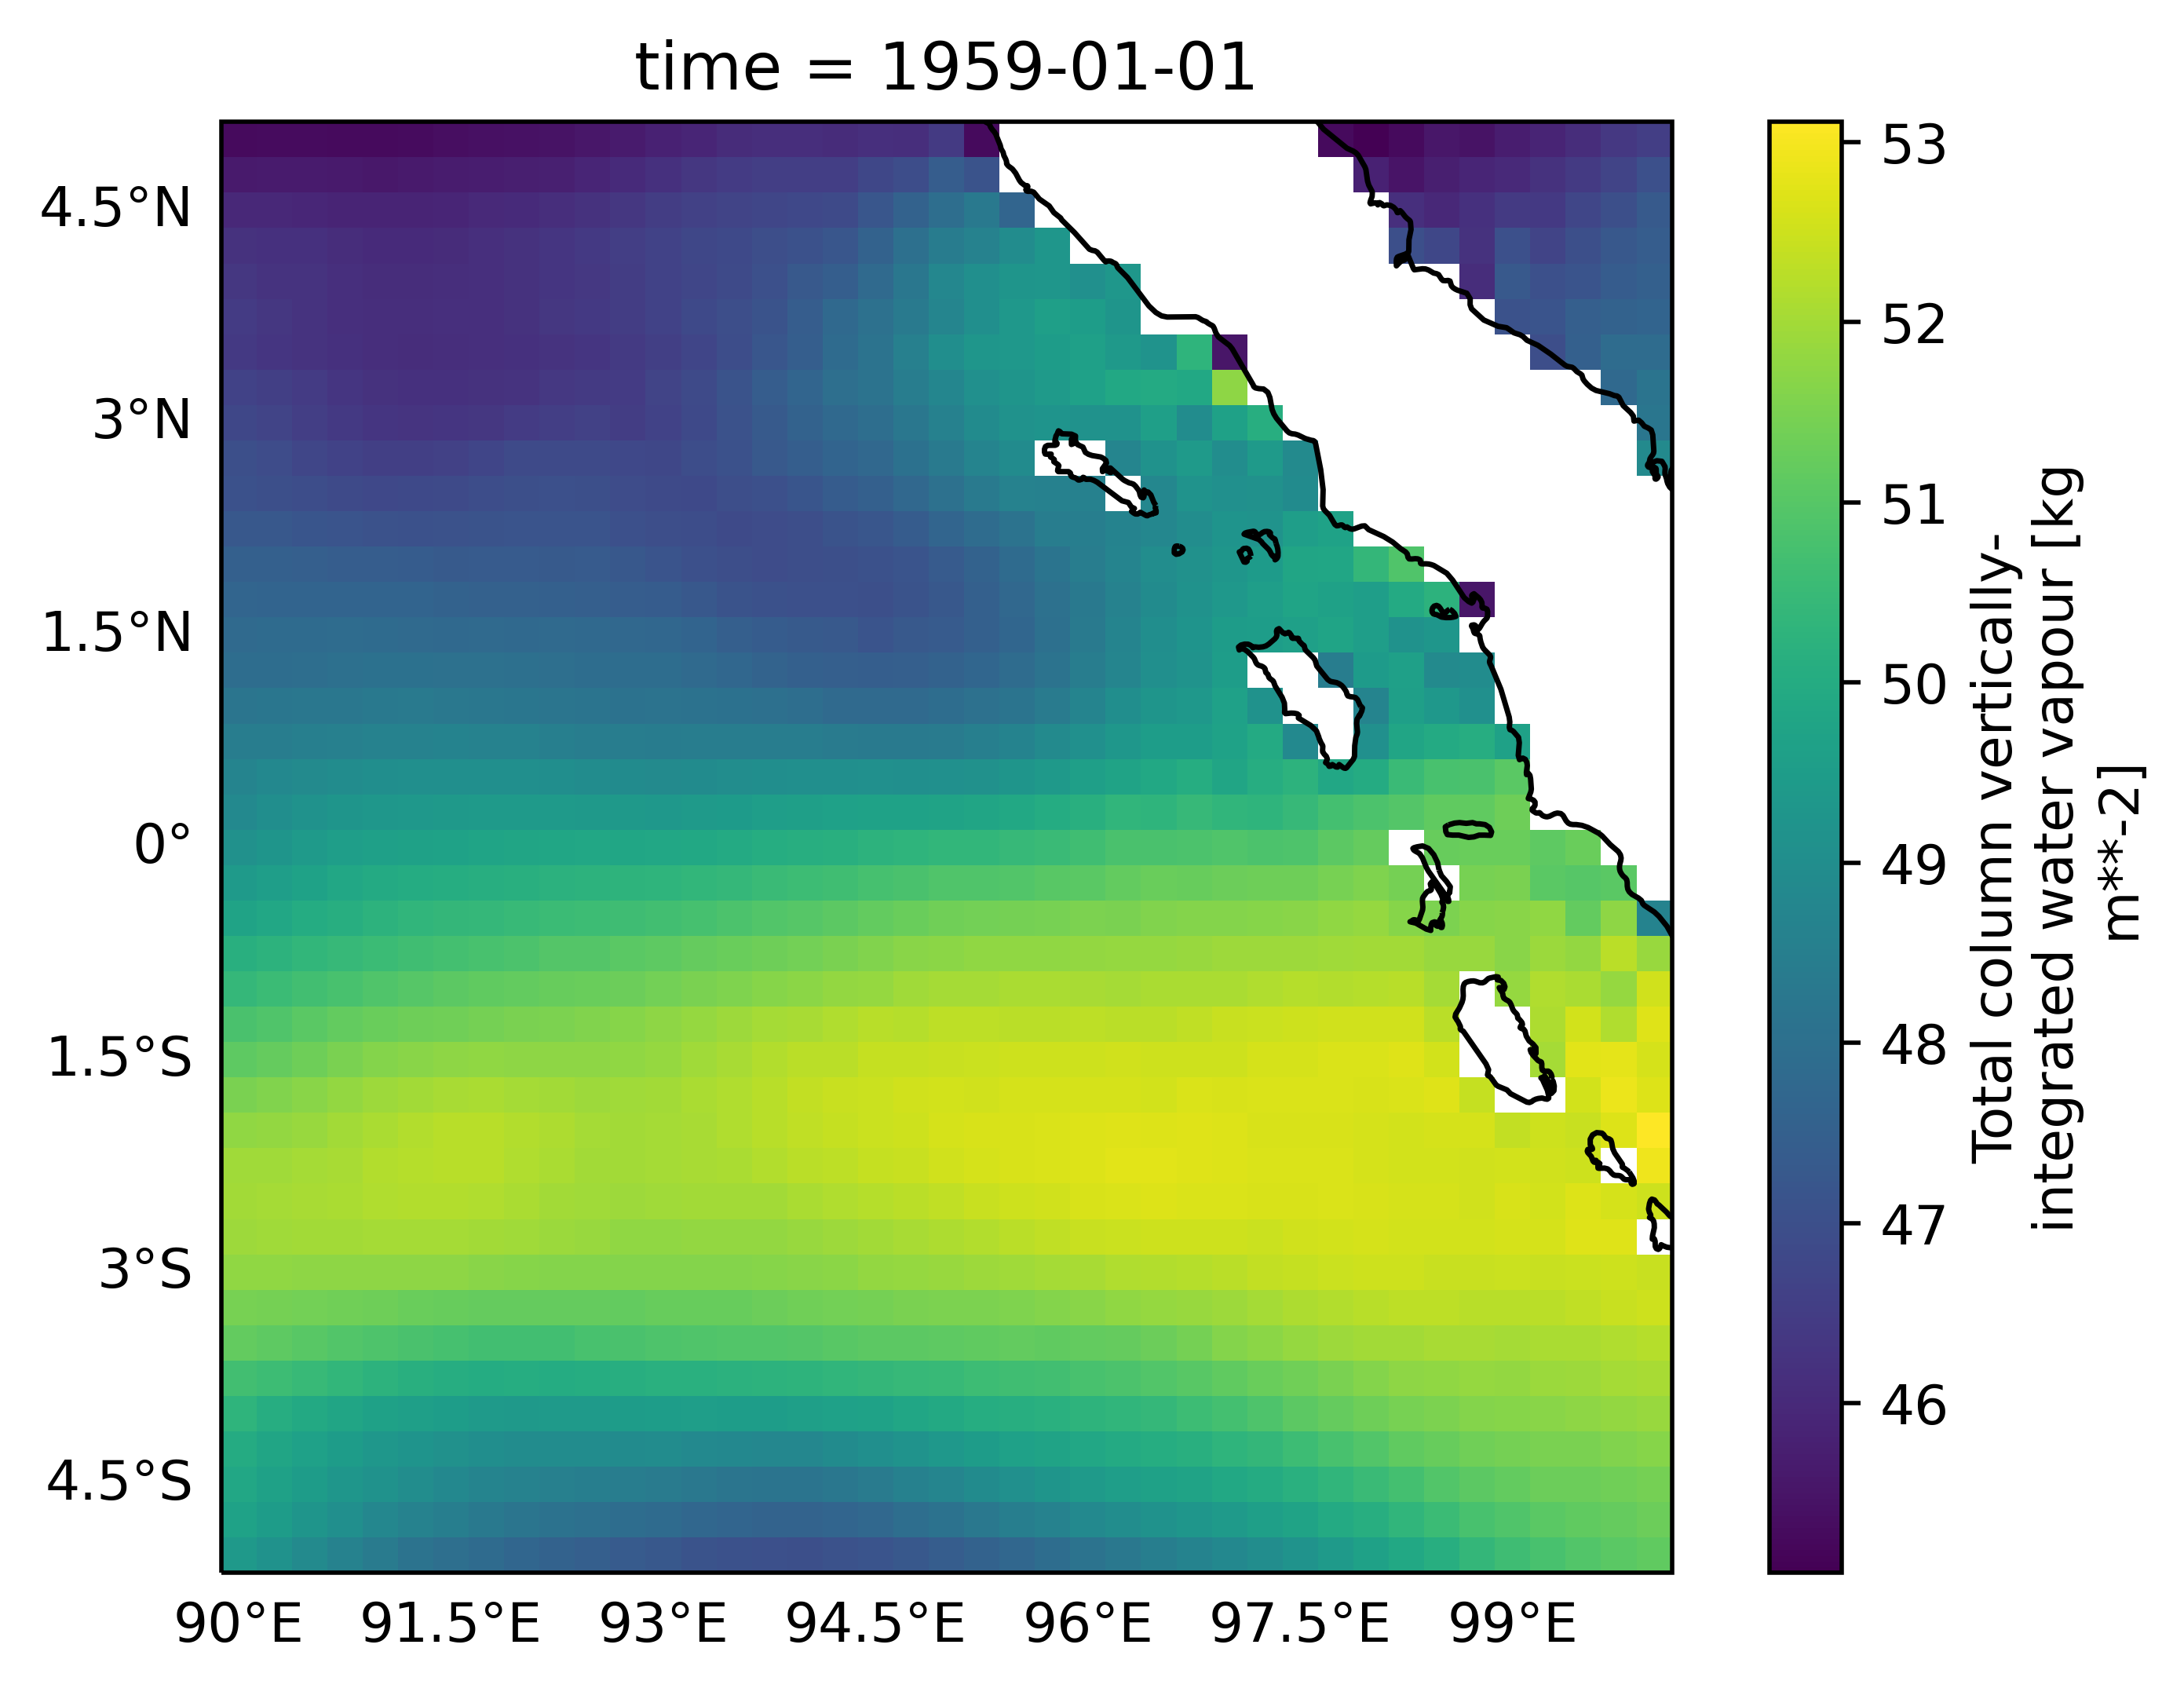

In [118]:
ax = plt.axes(projection = ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True, color="none") #color='none' makes gridlines invisible
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
ax.coastlines()
deca = clim2.tcwv.sel(time='1959-01-01')
deca.where(mask==0).plot() # 'RdBu', 'RdBu_r' are the best colourmaps, BrBG
plt.show()

In [ ]:
def pred(e,qnet,pwat,c):
    return e + qnet * pwat/(c-pwat)

pred1 = pred(E.values, Qdiv.values, Pwat.values, out)